In [ ]:
import numpy as np
import os

!pip install -q pyyaml h5py
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
from PIL import Image
from skimage.transform import resize
import datetime
import os

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_doc = np.random.permutation(open('/content/gdrive/MyDrive/ATML_CV_Dataset/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/ATML_CV_Dataset/val.csv').readlines())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -u "/content/gdrive/MyDrive/ATML_CV_Dataset/Project_data.zip" -d "/content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data"

unzip:  cannot find or open /content/gdrive/MyDrive/ATML_CV_Dataset/Project_data.zip, /content/gdrive/MyDrive/ATML_CV_Dataset/Project_data.zip.zip or /content/gdrive/MyDrive/ATML_CV_Dataset/Project_data.zip.ZIP.


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data/Project_data/train'
val_path = '/content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
batch_size = 20
x = 16
y = 120
z = 120
num_epochs = 30

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

Input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(8, (2,2,2), padding='same', input_shape=Input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(16, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,3,3), strides=(1,3,3)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(5, activation='softmax'))

In [ ]:
# optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True) #write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 8)   200       
                                                                 
 batch_normalization (Batch  (None, 16, 120, 120, 8)   32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 16, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 60, 60, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 16)     1040      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 60, 60, 16)     6

In [ ]:
mypath = "/content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data"
model_name = mypath + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = model_name + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
print('x=',x,'y=',y,'z=',z,'batch size=',batch_size,'epochs=',num_epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

2.14.0
x= 16 y= 120 z= 120 batch size= 20 epochs= 30
Source path =  /content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data/Project_data/train ; batch size = 40


<ipython-input-4-f0e311808174>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
15/17 [=========================>....] - ETA: 14s - loss: 1.8419 - categorical_accuracy: 0.2867

<ipython-input-4-f0e311808174>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.7975 - categorical_accuracy: 0.3002Source path =  /content/gdrive/MyDrive/ATML_CV_Dataset/Project_Data/Project_data/val ; batch size = 40

Epoch 1: saving model to /content/gdrive/MyDrive/ATML_CV_Dataset/Project_Datamodel_init_2023-11-0220_33_42.209174/model-00001-1.79748-0.30015-1.66501-0.16000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 189s 10s/step - loss: 1.7975 - categorical_accuracy: 0.3002 - val_loss: 1.6650 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.2765 - categorical_accuracy: 0.4902
Epoch 2: saving model to /content/gdrive/MyDrive/ATML_CV_Dataset/Project_Datamodel_init_2023-11-0220_33_42.209174/model-00002-1.27655-0.49020-1.88687-0.15000.h5
17/17 [==============================] - 148s 9s/step - loss: 1.2765 - categorical_accuracy: 0.4902 - val_loss: 1.8869 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.0572 - categorical_accuracy: 0.5897
Epoch 3: saving model to /content/gdrive/MyDrive/ATML_CV_Dataset/Project_Datamodel_init_2023-11-0220_33_42.209174/model-00003-1.05725-0.58974-2.20778-0.17000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
17/17 [==============================] - 132s 

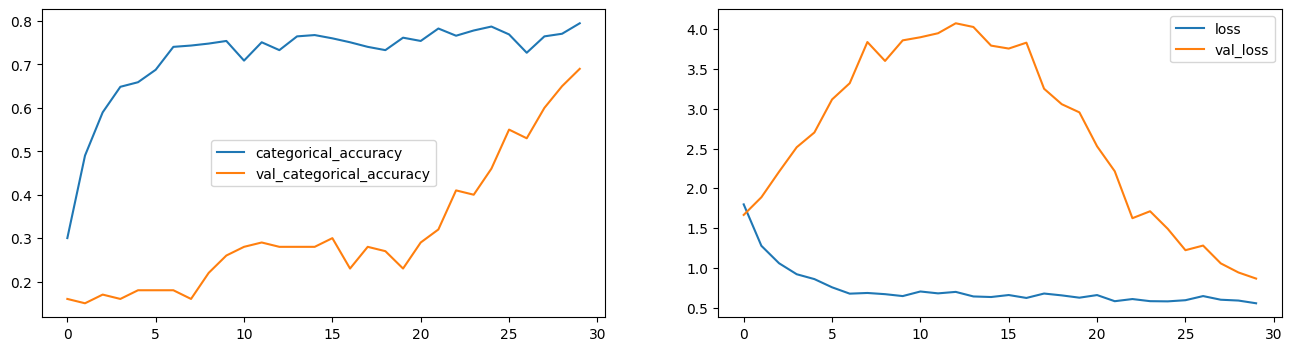

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

In [ ]:
batch_size =32 #experiment with the batch size
x = 16
y = 120
z = 120
num_epochs = 60 # choose the number of epochs

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

Input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same', input_shape=Input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'Model_2_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = model_name + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
print('x=',x,'y=',y,'z=',z,'batch size =',batch_size,'epochs=',num_epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Conv3D

In [ ]:
batch_size =16 #experiment with the batch size
x = 12
y = 120
z = 120
num_epochs = 50 # choose the number of epochs

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

Input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same', input_shape=Input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,3,3), strides=(1,3,3)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'Model_3_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = model_name + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
print('x=',x,'y=',y,'z=',z,'batch size =',batch_size,'epochs=',num_epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes [1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Conv3D

In [ ]:
batch_size = 32 #experiment with the batch size
x = 16
y = 120
z = 120
num_epochs = 50 # choose the number of epochs

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

#write your model here
Input_shape = (x, y, z, 3)

model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same', input_shape=Input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,3,3), strides=(1,3,3)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'Model_4_Conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = model_name + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
print('x=',x,'y=',y,'z=',z,'batch size =',batch_size,'epochs=',num_epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Model: CNN & GRU

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

units = 128
dense_neurons = 128
dropout=0.4
num_classes = 5
batch_size = 64
x = 16
y = 100
z = 100
num_epochs = 60
Input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'CNN_RNN' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq= 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## CNN & RNN (GRU)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

units = 128
dense_neurons = 128
dropout=0.5
num_classes = 5
batch_size = 32
x = 16
y = 120
z = 120
num_epochs = 60
Input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(dropout))

model.add(GRU(units))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

In [ ]:
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'CNN_RNN_Model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq= 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
print(tf. __version__)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

Transfer learning CNN & RNN (GRU)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.applications import mobilenet

units = 128
dense_neurons = 128
dropout=0.25
num_classes = 5
batch_size = 8
x = 16
y = 128
z = 128
num_epochs = 20
Input_shape = (x, y, z, 3)

mobilenet_transfer = mobilenet.MobileNet(input_shape = (y, z, 3), weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=Input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(units))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'CNN_RNN_Model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq= 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
print(tf. __version__)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Transfer learning CNN & RNN (LSTM)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout

from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

units = 128
dense_neurons = 128
dropout=0.5
num_classes = 5
batch_size = 32
x = 16
y = 120
z = 120
num_epochs = 50
Input_shape = (x, y, z, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(dropout))

model.add(LSTM(units))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

In [ ]:
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, x, y, z)
val_generator = generator(val_path, val_doc, batch_size, x, y, z)

In [ ]:
mypath = "/content/gdrive/My Drive/Colab Notebooks/Neural Networks Project - Gesture Recognition/Gesture recognition using CNN and RNN/"
model_name = mypath + 'CNN_RNN_Model_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq= 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks_list = [checkpoint, LR, tensorboard_callback]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
print(tf. __version__)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss','val_loss'])